IMPORT Packages

In [2]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
import sys
import numpy as np
import cv2
from PIL import Image

sys.path.append("/workspaces/NEBULA2")


Add Functions

In [25]:
 # hacky way to deal with the Pytorch 1.0 update
def recursion_change_bn(module):
    if isinstance(module, torch.nn.BatchNorm2d):
        module.track_running_stats = 1
    else:
        for i, (name, module1) in enumerate(module._modules.items()):
            module1 = recursion_change_bn(module1)
    return module

def load_labels():
    # prepare all the labels
    # scene category relevant
    file_name_category = 'categories_places365.txt'
    if not os.access(file_name_category, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
        os.system('wget ' + synset_url)
    classes = list()
    with open(file_name_category) as class_file:
        for line in class_file:
            classes.append(line.strip().split(' ')[0][3:])
    classes = tuple(classes)

    # indoor and outdoor relevant
    file_name_IO = 'IO_places365.txt'
    if not os.access(file_name_IO, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/IO_places365.txt'
        os.system('wget ' + synset_url)
    with open(file_name_IO) as f:
        lines = f.readlines()
        labels_IO = []
        for line in lines:
            items = line.rstrip().split()
            labels_IO.append(int(items[-1]) -1) # 0 is indoor, 1 is outdoor
    labels_IO = np.array(labels_IO)

    # scene attribute relevant
    file_name_attribute = 'labels_sunattribute.txt'
    if not os.access(file_name_attribute, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/labels_sunattribute.txt'
        os.system('wget ' + synset_url)
    with open(file_name_attribute) as f:
        lines = f.readlines()
        labels_attribute = [item.rstrip() for item in lines]
    file_name_W = 'W_sceneattribute_wideresnet18.npy'
    if not os.access(file_name_W, os.W_OK):
        synset_url = 'http://places2.csail.mit.edu/models_places365/W_sceneattribute_wideresnet18.npy'
        os.system('wget ' + synset_url)
    W_attribute = np.load(file_name_W)

    return classes, labels_IO, labels_attribute, W_attribute

def hook_feature(module, input, output):
    features_blobs.append(np.squeeze(output.data.cpu().numpy()))

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

def returnTF():
# load the image transformer
    tf = trn.Compose([
        trn.Resize((224,224)),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return tf


def load_model():
    # this model has a last conv feature map as 14x14

    # model_file = 'wideresnet18_places365.pth.tar'
    model_file = 'resnet50_places365.pth.tar'
    if not os.access(model_file, os.W_OK):
        os.system('wget http://places2.csail.mit.edu/models_places365/' + model_file)
        os.system('wget https://raw.githubusercontent.com/csailvision/places365/master/wideresnet.py')

    import wideresnet
    model = wideresnet.resnet18(num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)

    # hacky way to deal with the upgraded batchnorm2D and avgpool layers...
    for i, (name, module) in enumerate(model._modules.items()):
        module = recursion_change_bn(model)
    model.avgpool = torch.nn.AvgPool2d(kernel_size=14, stride=1, padding=0)

    model.eval()



    # the following is deprecated, everything is migrated to python36

    ## if you encounter the UnicodeDecodeError when use python3 to load the model, add the following line will fix it. Thanks to @soravux
    #from functools import partial
    #import pickle
    #pickle.load = partial(pickle.load, encoding="latin1")
    #pickle.Unpickler = partial(pickle.Unpickler, encoding="latin1")
    #model = torch.load(model_file, map_location=lambda storage, loc: storage, pickle_module=pickle)

    model.eval()
    # hook the feature extractor
    features_names = ['layer4','avgpool'] # this is the last conv layer of the resnet
    for name in features_names:
        model._modules.get(name).register_forward_hook(hook_feature)
    return model


In [27]:
# load the labels
classes, labels_IO, labels_attribute, W_attribute = load_labels()

In [28]:
# load the model
features_blobs = []
model = load_model()

--2022-02-24 15:36:17--  http://places2.csail.mit.edu/models_places365/alexnet_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.30.195.26
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.30.195.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233999051 (223M) [application/x-tar]
Saving to: ‘alexnet_places365.pth.tar’

     0K .......... .......... .......... .......... ..........  0%  302K 12m37s
    50K .......... .......... .......... .......... ..........  0%  606K 9m27s
   100K .......... .......... .......... .......... ..........  0% 35.3M 6m20s
   150K .......... .......... .......... .......... ..........  0% 39.9M 4m46s
   200K .......... .......... .......... .......... ..........  0%  615K 5m3s
   250K .......... .......... .......... .......... ..........  0% 45.5M 4m13s
   300K .......... .......... .......... .......... ..........  0% 54.9M 3m38s
   350K .......... .......... .......... .......... .

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "features.0.weight", "features.0.bias", "features.3.weight", "features.3.bias", "features.6.weight", "features.6.bias", "features.8.weight", "features.8.bias", "features.10.weight", "features.10.bias", "classifier.1.weight", "classifier.1.bias", "classifier.4.weight", "classifier.4.bias", "classifier.6.weight", "classifier.6.bias". 

In [6]:
# load the transformer
tf = returnTF() # image transformer

In [7]:
# get the softmax weight
params = list(model.parameters())
weight_softmax = params[-2].data.numpy()
weight_softmax[weight_softmax<0] = 0

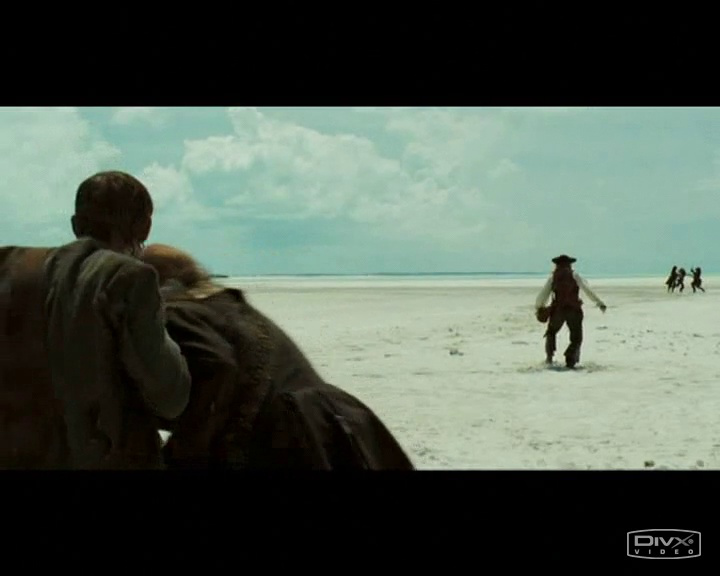

In [19]:
# load the test image
# img_url = 'http://places.csail.mit.edu/demo/6.jpg'
# os.system('wget %s -q -O test.jpg' % img_url)
frame_file = '/workspaces/data/Movies/92354428/frame0230.jpg'
img = Image.open(frame_file)
img.show()
input_img = V(tf(img).unsqueeze(0))


In [20]:
# forward pass
logit = model.forward(input_img)
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()


Show Indoor/outdoor, scene categories & scene attributes

In [22]:
# output the IO prediction
io_image = np.mean(labels_IO[idx[:10]]) # vote for the indoor or outdoor
if io_image < 0.5:
    print('--TYPE OF ENVIRONMENT: indoor')
else:
    print('--TYPE OF ENVIRONMENT: outdoor')

# output the prediction of scene category
print('--SCENE CATEGORIES:')
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# output the scene attributes
responses_attribute = W_attribute.dot(features_blobs[1])
idx_a = np.argsort(responses_attribute)
print('--SCENE ATTRIBUTES:')
print(', '.join([labels_attribute[idx_a[i]] for i in range(-1,-10,-1)]))

--TYPE OF ENVIRONMENT: outdoor
--SCENE CATEGORIES:
0.228 -> home_theater
0.169 -> movie_theater/indoor
0.059 -> grotto
0.032 -> aquarium
0.030 -> arena/performance
--SCENE ATTRIBUTES:
natural light, open area, boating, no horizon, man-made, natural, swimming, far-away horizon, ocean


Generate and show class activation mapping

Class activation map is saved as cam.jpg


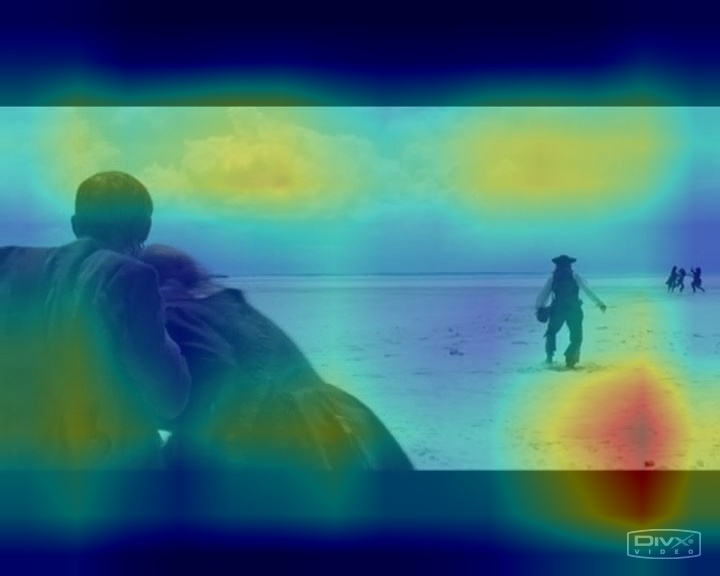

In [23]:

# generate class activation mapping
print('Class activation map is saved as cam.jpg')
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
img = cv2.imread(frame_file)
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.4 + img * 0.5
cv2.imwrite('/tmp/cam.jpg', result)
cam_img = Image.open('/tmp/cam.jpg')
cam_img.show()